Fix the seeds

In [1]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [2]:
!pip -q install torch
!pip -q install torchvision

In [3]:
import torch
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel mesurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  True 



Here are the functions, which create mesurements vectror for all patterns in Hadamard basis

In [4]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [5]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Dataset with single-pixel mesuarements and their class labels

In [6]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MesurementDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        self.labels = mnist.targets
        images = mnist.data
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize(32)])

        self.target_images = transform(images)

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.labels[indx]

    def __len__(self):
        return len(self.measurements)

In [7]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MesurementDataset(MNIST(root='./MNIST', train=True, download=True))
test_set = MesurementDataset(MNIST(root='./MNIST', train=False, download=True))

batch_size = 64
# if you use cpu, you have to delete the num_workers
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [8]:
import numpy as np

variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [9]:
most_important = np.argsort(variance)[-64:]

How our data look like

(array([ 1.,  2.,  1., 10., 29., 17.,  3.,  0.,  0.,  1.]),
 array([-117.36766052,  -91.46697998,  -65.56629181,  -39.66561127,
         -13.76492596,   12.13575745,   38.0364418 ,   63.93712616,
          89.8378067 ,  115.73849487,  141.63917542]),
 <BarContainer object of 10 artists>)

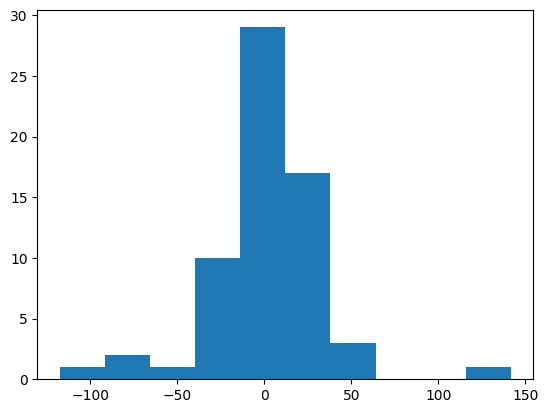

In [10]:
import matplotlib.pyplot as plt

plt.hist(train_set[0][0][most_important].numpy())

# Model

In [11]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 64)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

Class for plots

In [12]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = [] #reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
           self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len,len(data[key]))
            if len(data) > 1:
               ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel('step')
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    """
        groups list of keys like [['loss_train','loss_val'],['accuracy']]
        All charts within a group will be plot in the same axis
    """
    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48//n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Accuracy

In [13]:
def calculate_accuracy(pred_l, real_l):
    correct, total = 0, 0
    _, predicted = torch.max(pred_l.data, 1) # get predicted class
    total += real_l.size(0) # all examples
    correct += (predicted == labels.to(device)).sum().item() # correct predictions
    return correct / total

Training our network

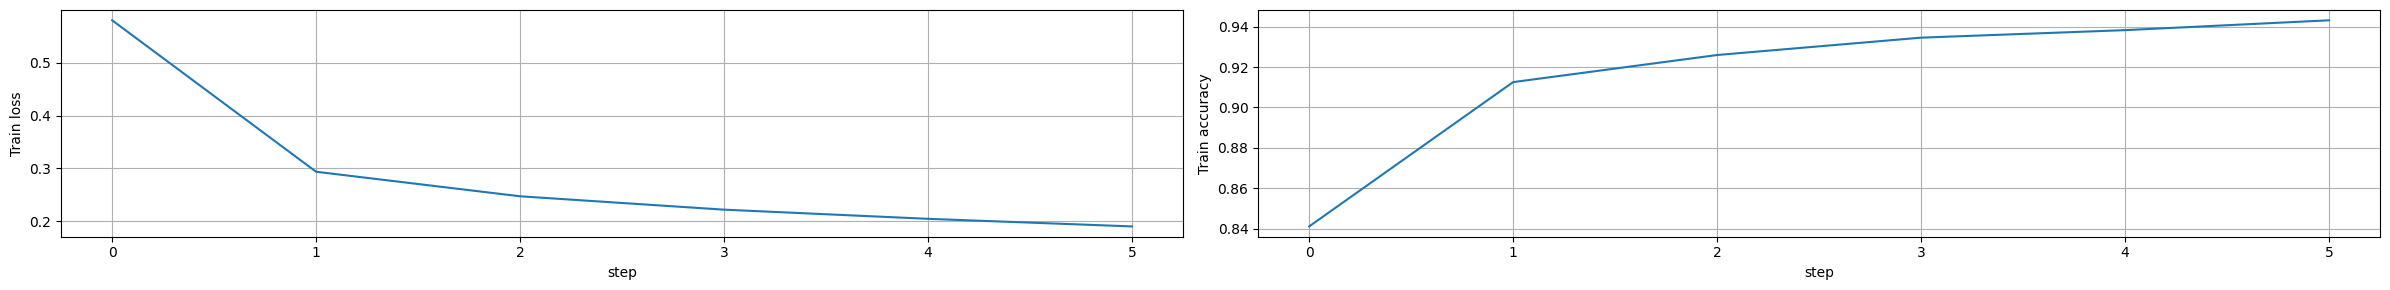

100%|██████████| 6/6 [00:29<00:00,  4.84s/it]


In [14]:
from tqdm import trange

num_epochs = 6
epochs = trange(num_epochs)

# noise characteristics to simulate the real experiment
alpha = 0.0 # you can change the level of noise
sigma = 100
mu = -0.4242

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

pp = ProgressPlotter()
pp.set_title(f"alpha=0")

for epoch in epochs:
    train_loss = 0
    train_acc = 0
    for i, batch in enumerate(train_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        optimizer.zero_grad()
        x = measurements[:, most_important].to(device)
        noise = torch.tensor(alpha * (sigma * np.random.randn(len(x), len(most_important)) + mu)).to(device)
        x_noised = x + noise
        pred = model(x_noised.float())

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(pred, labels)

    test_loss = 0
    test_acc = 0
    for batch in test_loader:
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)
        noise = torch.tensor(alpha * (sigma * np.random.randn(len(x), len(most_important)) + mu)).to(device)
        x_noised = x + noise
        pred = model(x_noised.float())

        loss = criterion(pred, labels)

        test_loss += loss.item()
        acc = calculate_accuracy(pred, labels)
        test_acc += acc

    pp.add_scalar('Train loss', train_loss / len(train_loader))
    pp.add_scalar('Train accuracy', train_acc / len(train_loader))
    pp.display(['Train loss','Train accuracy'])